In [1]:
%matplotlib inline

import os

# Make sure we're running from the spam/ directory
if os.path.basename(os.getcwd()) == "snorkel-tutorials":
    os.chdir("spam")

# Turn off TensorFlow logging messages
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# For reproducibility
os.environ["PYTHONHASHSEED"] = "0"

In [2]:
import pandas as pd


DISPLAY_ALL_TEXT = False

pd.set_option("display.max_colwidth", 0 if DISPLAY_ALL_TEXT else 50)

In [3]:
# Download the spaCy english model
! python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.6 MB 14.0 MB/s eta 0:00:01
You should consider upgrading via the '/home/jayli/label/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
from utils import load_spam_dataset

df_train, df_test = load_spam_dataset()

# We pull out the label vectors for ease of use later
Y_test = df_test.label.values

In [6]:
df_train.head()

,author,date,text,label,video
0,Alessandro leite,2014-11-05T22:21:36,pls http://www10.vakinha.com.br/VaquinhaE.aspx...,-1.0,1
1,Salim Tayara,2014-11-02T14:33:30,"if your like drones, plz subscribe to Kamal Ta...",-1.0,1
2,Phuc Ly,2014-01-20T15:27:47,go here to check the views :3﻿,-1.0,1
3,DropShotSk8r,2014-01-19T04:27:18,"Came here to check the views, goodbye.﻿",-1.0,1
4,css403,2014-11-07T14:25:48,"i am 2,126,492,636 viewer :D﻿",-1.0,1


In [30]:
# For clarity, we define constants to represent the class labels for spam, ham, and abstaining.
ABSTAIN = -1
HAM = 0
SPAM = 1

In [31]:
df_train

,author,date,text,label,video
0,Alessandro leite,2014-11-05T22:21:36,pls http://www10.vakinha.com.br/VaquinhaE.aspx...,-1.0,1
1,Salim Tayara,2014-11-02T14:33:30,"if your like drones, plz subscribe to Kamal Ta...",-1.0,1
2,Phuc Ly,2014-01-20T15:27:47,go here to check the views :3﻿,-1.0,1
3,DropShotSk8r,2014-01-19T04:27:18,"Came here to check the views, goodbye.﻿",-1.0,1
4,css403,2014-11-07T14:25:48,"i am 2,126,492,636 viewer :D﻿",-1.0,1
...,...,...,...,...,...
443,Themayerlife,NaN,Check out my mummy chanel!,-1.0,4
444,Fill Reseni,2015-05-27T17:10:53.724000,The rap: cool Rihanna: STTUUPID﻿,-1.0,4
445,Greg Fils Aimé,NaN,I hope everyone is in good spirits I&#39;m a h...,-1.0,4
446,Lil M,NaN,Lil m !!!!! Check hi out!!!!! Does live the wa...,-1.0,4


In [6]:
df_train[["author", "text", "video"]].sample(20, random_state=2)

,author,text,video
4,ambareesh nimkar,"""eye of the tiger"" ""i am the champion"" seems l...",2
87,pratik patel,"mindblowing dance.,.,.superbbb song﻿",3
14,RaMpAgE420,Check out Berzerk video on my channel ! :D,4
80,Jason Haddad,"Hey, check out my new website!! This site is a...",1
104,austin green,Eminem is my insperasen and fav﻿,4
305,M.E.S,hey guys look im aware im spamming and it piss...,4
22,John Monster,Οh my god ... Roar is the most liked video at ...,2
338,Alanoud Alsaleh,I started hating Katy Perry after finding out ...,2
336,Leonardo Baptista,http://www.avaaz.org/po/petition/Youtube_Corpo...,1
143,UKz DoleSnacher,Remove This video its wank﻿,1


# Define Labeling Function

In [7]:
from snorkel.labeling import labeling_function

from snorkel.preprocess import preprocessor
from textblob import TextBlob


@labeling_function()
def check(x):
    return SPAM if "check" in x.text.lower() else ABSTAIN


@labeling_function()
def check_out(x):
    return SPAM if "check out" in x.text.lower() else ABSTAIN


@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x


@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    return HAM if x.polarity > 0.9 else ABSTAIN

@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    return HAM if x.subjectivity >= 0.5 else ABSTAIN

In [8]:
import re


@labeling_function()
def regex_check_out(x):
    return SPAM if re.search(r"check.*out", x.text, flags=re.I) else ABSTAIN

In [9]:
from snorkel.labeling import LabelingFunction


def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN


def make_keyword_lf(keywords, label=SPAM):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )


"""Spam comments talk about 'my channel', 'my video', etc."""
keyword_my = make_keyword_lf(keywords=["my"])

"""Spam comments ask users to subscribe to their channels."""
keyword_subscribe = make_keyword_lf(keywords=["subscribe"])

"""Spam comments post links to other channels."""
keyword_link = make_keyword_lf(keywords=["http"])

"""Spam comments make requests rather than commenting."""
keyword_please = make_keyword_lf(keywords=["please", "plz"])

"""Ham comments actually talk about the video's content."""
keyword_song = make_keyword_lf(keywords=["song"], label=HAM)

In [10]:
@labeling_function()
def short_comment(x):
    """Ham comments are often short, such as 'cool video!'"""
    return HAM if len(x.text.split()) < 5 else ABSTAIN

In [11]:
from snorkel.preprocess.nlp import SpacyPreprocessor

# The SpacyPreprocessor parses the text in text_field and
# stores the new enriched representation in doc_field
spacy = SpacyPreprocessor(text_field="text", doc_field="doc", memoize=True)

@labeling_function(pre=[spacy])
def has_person(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN
    
from snorkel.labeling.lf.nlp import nlp_labeling_function


@nlp_labeling_function()
def has_person_nlp(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN

In [12]:
from snorkel.labeling import PandasLFApplier

lfs = [
    keyword_my,
    keyword_subscribe,
    keyword_link,
    keyword_please,
    keyword_song,
    regex_check_out,
    short_comment,
    has_person_nlp,
    textblob_polarity,
    textblob_subjectivity,
]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)

100%|██████████| 1586/1586 [00:15<00:00, 104.67it/s]


In [13]:
L_train

array([[-1, -1,  1, ..., -1, -1, -1],
       [-1,  1, -1, ..., -1, -1,  0],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [ 1,  1, -1, ..., -1, -1,  0],
       [-1,  1, -1, ..., -1, -1,  0],
       [ 1, -1, -1, ..., -1, -1, -1]])

In [14]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
keyword_my,0,[1],0.198613,0.186633,0.113493
keyword_subscribe,1,[1],0.127364,0.109079,0.070618
keyword_http,2,[1],0.119168,0.102144,0.085120
keyword_please,3,[1],0.112232,0.109710,0.058008
keyword_song,4,[0],0.141866,0.111602,0.043506
regex_check_out,5,[1],0.233922,0.134931,0.089533
short_comment,6,[0],0.225725,0.152585,0.074401
has_person_nlp,7,[0],0.140605,0.106557,0.047919
textblob_polarity,8,[0],0.035309,0.031526,0.005044
textblob_subjectivity,9,[0],0.357503,0.267339,0.160151


In [15]:
df_train.iloc[L_train[:, 1] == SPAM].sample(10, random_state=1)

,author,date,text,label,video
421,Yuliya Meow,NaN,"HEY GUYS!!! ❤❤❤❤❤❤❤ BEFORE YOU IGNORE ME, PLE...",-1.0,4
167,GORHD/TV Studio,2014-11-25T16:15:50.566000,subscribers please`﻿,-1.0,3
287,M.E.S,NaN,hey its M.E.S here I&#39;m a young up and comi...,-1.0,4
344,Desert Loner,2014-12-25T19:52:25.333000,want a sub? tell me about your channel and i w...,-1.0,3
332,OFFICIAL LEXIS,2014-11-04T20:22:21,Hi everyone! Do you like music? Then why not c...,-1.0,1
164,ViralVinesHD,2014-08-18T00:25:09.584000,"Like this comment, guys i just started up a ne...",-1.0,3
48,"TelePricol - FUNNY VIDEOS,ЛУЧШИЕ ПРИКОЛЫ",2015-05-17T14:02:31.882000,SUBSCRIBE TO MY CHANNEL﻿,-1.0,3
166,Christopher Pete S.,2014-09-07T22:39:21,Subscribe and u are gonna hear me roar ;)﻿,-1.0,2
212,Kirsty Brown,2014-01-20T16:41:27,Plz subscribe to my channel and I will subscri...,-1.0,1
35,BaconBro HD,2014-01-20T21:11:52,Subscribe ME!﻿,-1.0,1


In [16]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_test = applier.apply(df=df_test)

100%|██████████| 250/250 [00:02<00:00, 90.54it/s]


In [17]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

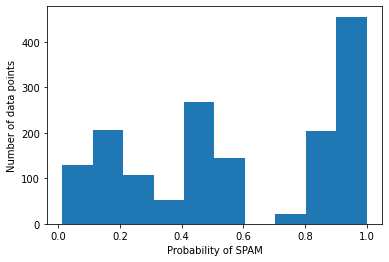

In [18]:
import matplotlib.pyplot as plt

def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of SPAM")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, SPAM])

## Filter unlabeled samples

In [19]:
from snorkel.labeling import filter_unlabeled_dataframe

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

In [20]:
df_train_filtered = df_train_filtered.reset_index(drop=True)
df_train_filtered

,author,date,text,label,video
0,Alessandro leite,2014-11-05T22:21:36,pls http://www10.vakinha.com.br/VaquinhaE.aspx...,-1.0,1
1,Salim Tayara,2014-11-02T14:33:30,"if your like drones, plz subscribe to Kamal Ta...",-1.0,1
2,Giang Nguyen,2014-11-06T04:55:41,https://www.facebook.com/teeLaLaLa﻿,-1.0,1
3,King uzzy,2014-11-07T23:19:08,Can we reach 3 billion views by December 2014? ﻿,-1.0,1
4,John Plaatt,2014-11-07T22:22:29,On 0:02 u can see the camera man on his glasse...,-1.0,1
...,...,...,...,...,...
1405,Themayerlife,NaN,Check out my mummy chanel!,-1.0,4
1406,Fill Reseni,2015-05-27T17:10:53.724000,The rap: cool Rihanna: STTUUPID﻿,-1.0,4
1407,Greg Fils Aimé,NaN,I hope everyone is in good spirits I&#39;m a h...,-1.0,4
1408,Lil M,NaN,Lil m !!!!! Check hi out!!!!! Does live the wa...,-1.0,4


# Considering the sentence at index 1364

In [21]:
# pick one example in the training data
df_tmp = df_train_filtered[1364:1365]
df_tmp.reset_index(drop=True)
print(df_tmp)
print(df_tmp.at[1364,'text'])
print('the predicted label is', label_model.predict(L_train)[1364])

               author date                                               text  \
1364  Unbeweavable Co  NaN  For all you ladies out there......  Check out ...   

      label  video  
1364   -1.0      4  
For all you ladies out there......  Check out this link!  You&#39;ll find the hottest hairstyles and the latest trends for women!  Go to this site and you&#39;ll upgrade your hairstyles and fashion senses to a higher level!  Don&#39;t get left behind!     ---&gt;   goo.gl\BxrOSR
the predicted label is 1


# Function to retrain the model and see if the label has changed

In [22]:
def retrain_model(lfs, idx, orig_label):
    applier = PandasLFApplier(lfs=lfs)
    L_train = applier.apply(df=df_train)
    L_test = applier.apply(df=df_test)
    
    label_model = LabelModel(cardinality=2, verbose=True)
    label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)
    
    df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train)
    df_train_filtered = df_train_filtered.reset_index(drop=True)

    if idx not in df_train_filtered.index:
        return False
    
    df_tmp = df_train_filtered[idx:idx+1]
    df_tmp.reset_index(drop=True)
    return orig_label == label_model.predict(L_train)[idx]

In [23]:
# function to generate all the sub lists
def sub_lists (l):
    base = []  
    lists = [base]
    for i in range(len(l)):
        orig = lists[:]
        new = l[i]
        for j in range(len(lists)):
            lists[j] = lists[j] + [new]
        lists = orig + lists
          
    return lists

# See which common labeling functions always participate in giving the sample the label SPAM

In [24]:
lfs_subsets = sub_lists(lfs)
lfs_subsets = [s for s in lfs_subsets if len(s) > 2]
print('number of subsets = ', len(lfs_subsets))

sets_give_same_label = []
for s in lfs_subsets[30:]:
    if retrain_model(s, 1364, SPAM):
        sets_give_same_label.append(s)

number of subsets =  968


100%|██████████| 250/250 [00:00<00:00, 5340.48it/s]


KeyboardInterrupt: 

In [ ]:
lf_intersection = set(sets_give_same_label[0])

for s in sets_give_same_label:
    lf_intersection = lf_intersection.intersection(s)
    
lf_intersection

# Compute Shapley values

In [ ]:
import math
import numpy as np

def shapley(lf):
    lfs_subsets = sub_lists(lfs)
    lfs_subsets = [s for s in lfs_subsets if len(s) > 2 and lf not in s] # remove irrelevant subsets that would get Shapley value 0
    
    n = len(lfs)
    
    shap = 0
    for s in lfs_subsets:
#         if lf not in s:
        s_aug = s + [lf]
        v = np.subtract(retrain_model(list(set(s_aug)), 1364, SPAM), retrain_model(s, 1364, SPAM), dtype=np.float32)
#         else:
#             v = 0
        shap += ((math.factorial(len(s)) * math.factorial(n - len(s) - 1)) / math.factorial(n)) * v
        
    return shap

In [ ]:
shapley(keyword_my)

## For SHAP we need to train a target model from e.g. scikit-learn since it cannot be applied directly on a Snorkel model

In [ ]:
import shap

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

# explain the model's predictions using SHAP
explainer = shap.Explainer(label_model)
shap_values = explainer(L_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

# Compute Anchor Explanation

In [ ]:
from anchor import anchor_text

def predict_lr_with_idx(idx):
    df_tmp = df_train_filtered[idx:idx+1]
    df_tmp.reset_index(drop=True)
    def predict_lr(texts):
        newdf = pd.DataFrame(np.repeat(df_tmp.values, len(texts), axis=0)).reset_index(drop=True)

        for i in range(len(texts)):
            newdf.at[i, 'text'] = texts[i]
        L_tmp = applier.apply(df=newdf)
        res = label_model.predict(L=L_tmp)
        res_type = []
        for x in res:
            res_type.append(type(x))
        return res
    
    return predict_lr

In [ ]:
import spacy
nlp1 = spacy.load('en_core_web_lg')

In [ ]:
explainer = anchor_text.AnchorText(nlp1, [HAM, SPAM], use_unk_distribution=True)

In [ ]:
import pandas as pd
np.random.seed(3)
text = 'subscribe to my channel  /watch?v=NxK32i0HkDs'
pred = predict_lr_with_idx(1356)([text])[0]
alternative =  1 - predict_lr_with_idx(1356)([text])[0]
print('Prediction: %s' % pred)

In [ ]:
exp = explainer.explain_instance(text, predict_lr_with_idx(1356), threshold=0.98)

In [ ]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print()
print('Examples where anchor applies and model predicts %s:' % pred)
print()
print('\n'.join([x[0] for x in exp.examples(only_same_prediction=True)]))
print()
print('Examples where anchor applies and model predicts %s:' % alternative)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_different_prediction=True)]))